In [1]:
# Download the Oxford Pets dataset
from fastai.vision.all import URLs, untar_data

path = untar_data(URLs.PETS)
path

Path('/Users/mohitsakhuja/.fastai/data/oxford-iiit-pet')

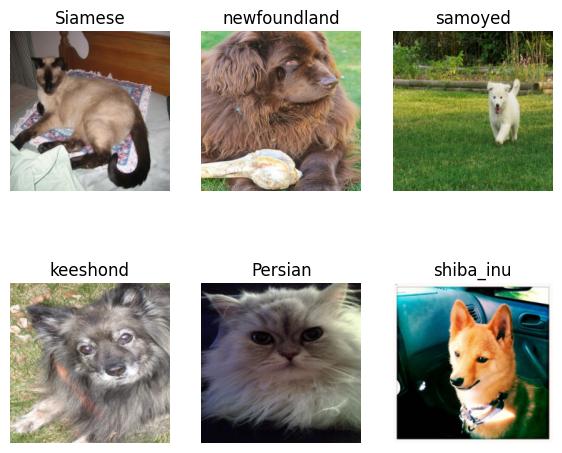

In [3]:
from fastai.vision.all import ImageDataLoaders, get_image_files, Resize
import re

def get_breed_name(x):
    """Extract breed name from Oxford Pets dataset filename"""
    # Filenames are in format: breed_name_number.jpg
    # We need to extract the breed name (everything before the last underscore and number)
    filename = x
    # Remove the file extension
    name_without_ext = filename.split('.')[0]
    # Split by underscore and remove the last part (which is typically a number)
    parts = name_without_ext.split('_')
    # Join all parts except the last one (assuming last part is number)
    if len(parts) > 1 and parts[-1].isdigit():
        breed_name = '_'.join(parts[:-1])
    else:
        breed_name = name_without_ext
    return breed_name

dls = ImageDataLoaders.from_name_func(
    path,
    get_image_files(path / "images"),
    label_func=get_breed_name,
    valid_pct=0.2,
    item_tfms=Resize(224, method="squish"),
)

dls.show_batch(max_n=6, figsize=(7, 6))

In [4]:
# Check and set device type as per architecture
import torch

device_type = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device = torch.device(device_type)

device_type

'mps'

In [5]:
from fastai.vision.all import vision_learner, error_rate

def train_model(model, num_epoch=1):
    learner = vision_learner(dls, model, metrics=error_rate)
    learner.model.to(device)
    learner.fine_tune(num_epoch)
    return learner

In [6]:
# Train a Resnet18 model
from fastai.vision.all import resnet18

learner = train_model(resnet18, 2)

epoch,train_loss,valid_loss,error_rate,time
0,1.584204,0.442600,0.139378,00:42


epoch,train_loss,valid_loss,error_rate,time
0,0.521787,0.333838,0.102842,00:51
1,0.240979,0.306971,0.086604,00:52


In [12]:
# Upload test image
from ipywidgets import widgets

uploader = widgets.FileUpload(
    description="Upload an image",
    accept=".jpg,.jpeg,.png",
    multiple=False,
)

uploader

FileUpload(value=(), accept='.jpg,.jpeg,.png', description='Upload an image')

In [ ]:
# Test the model with the uploaded image
from fastai.vision.all import PILImage
import torch

if uploader.value:
    img_bytes = bytes(uploader.value[0]['content'])
    img = PILImage.create(img_bytes)
    prediction, pred_idx, probs = learner.predict(img)

    # Get the category with highest probability
    max_prob_idx = torch.argmax(probs)
    max_prob = probs[max_prob_idx]
    predicted_breed = dls.vocab[max_prob_idx]

    print(f"Predicted breed: {predicted_breed}")
    print(f"Confidence: {max_prob:.4f}")
    print(f"\nTop 5 predictions:")

    # Show top 5 predictions
    sorted_probs, sorted_indices = torch.sort(probs, descending=True)
    for i in range(min(5, len(dls.vocab))):
        breed = dls.vocab[sorted_indices[i]]
        probability = sorted_probs[i]
        print(f"  {i+1}. {breed}: {probability:.4f}")
else:
    print("Please upload an image first")

Predicted breed: english_cocker_spaniel
Confidence: 0.7287

Top 5 predictions:
  1. english_cocker_spaniel: 0.7287
  2. beagle: 0.1447
  3. wheaten_terrier: 0.0297
  4. shiba_inu: 0.0247
  5. english_setter: 0.0199
